In [236]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect
from time import sleep
sys.path.append('../util')
from meters import ThroughputMeter
from ncgen import *
from grids import *
import netCDF4
import numpy as np

In [237]:
def write_netcdf_file(timescale, time_major=True):
    print("Creating a time-{} NetCDF file with {}x{} grid and {} time steps".format('major' if time_major else 'minor', grid['lon']['count'], grid['lat']['count'],len(timescale)))
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='../tmp') as f:
        nc = get_base_nc(f.name, world_125k)
        nc = add_simple_time(nc, timescale)
        nc = add_climo_data(nc, 'var_0', timemajor=time_major)
        nc.close()
    print("file size: {}".format(os.path.getsize(f.name)))
    return f

../tmp path in the Docker container points at rotating media storage.

In [238]:
def netcdf_read_test(f):
    results = []
    # Open the file just created
    nc = netCDF4.Dataset(f.name, 'r')
    with ThroughputMeter() as t:
        for i in range(nc.variables['var_0'].shape[0]):
            a = nc.variables['var_0'][i,:,:]
    results.append((time_major, len(timescale), t.megabytes_per_second(nc.variables['var_0'])))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    del nc
    print("Removing {}".format(f.name))
    os.remove(f.name)
    f.close()
    collect()
    return results

In [239]:
def clear_host_cache():
    """ Ensures that temp files created for subsequent readout are not read from cache, but from disk.
        This requires triggering the script clear_host_cache.sh to carry out the clearing of system cache
        by way of modifying a .tmp file in the /app/watch directory, which is linked to a real directory on the host
        (make sure it has no other .tmp files in it you do not want deleted).
        Make sure to run /path/on/host/to/notebooks/sudo clear_host_cache.sh &> /dev/null on the host before starting 
        this test suite."""
    os.system('touch /app/watch/cc_sig.tmp')
    while True:
        try:
            open('/app/watch/cc_sig.tmp', 'w')
            f.write('.') # modify the file to trigger clear_host_cache.sh to carry out cache clearing
        except: # clear_host_cache.sh will delete the temp file after the cache is cleared, which will cause this exception
            print('host cache cleared')
            f.close()
            break

###Run time-major test for world_125k grid at monthly timescale:

In [240]:
grid = world_125k
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 256x128 grid and 1800 time steps
file size: 235945088


####Need to empty the filesystem buffers and cache after writing the file, to ensure it is read back from disk and not memory:

In [241]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7548        133        770          3       5250
-/+ buffers/cache:       2295       5386
Swap:            0          0          0


In [242]:
!sync

In [243]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [244]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       5083       2597        775          0       2816
-/+ buffers/cache:       2266       5414
Swap:            0          0          0


In [245]:
results_tmaj_world_125k_monthly = netcdf_read_test(testfile)

225.000 MB in 1.22 seconds at 183.712 MB / sec
Removing /app/tmp/tmplpd0oekg.nc


In [246]:
results_tmaj_world_125k_monthly

[(True, 1800, 183.71220682200041)]

###Run time-minor test for world_125k grid at monthly timescale:

In [247]:
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 256x128 grid and 1800 time steps
file size: 235945088


In [248]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3331       4349        795          1       1107
-/+ buffers/cache:       2223       5458
Swap:            0          0          0


In [249]:
!sync

In [250]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [251]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3100       4581        802          0        887
-/+ buffers/cache:       2212       5469
Swap:            0          0          0


In [252]:
results_tmin_world_125k_monthly = netcdf_read_test(testfile)

225.000 MB in 1.18 seconds at 190.995 MB / sec
Removing /app/tmp/tmpw1llk2ai.nc


In [253]:
results_tmin_world_125k_monthly

[(False, 1800, 190.99482136250705)]

###Run time-major test for canada_5k grid at monthly timescale:

In [254]:
grid = canada_5k
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1068x510 grid and 1800 time steps
file size: 235945088


In [255]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3282       4399        828          1       1141
-/+ buffers/cache:       2139       5541
Swap:            0          0          0


In [256]:
!sync

In [257]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [258]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3037       4643        828          0        914
-/+ buffers/cache:       2122       5558
Swap:            0          0          0


In [259]:
results_tmaj_canada_5k_monthly = netcdf_read_test(testfile)

225.000 MB in 1.17 seconds at 191.794 MB / sec
Removing /app/tmp/tmpfojs179i.nc


In [260]:
results_tmaj_canada_5k_monthly

[(True, 1800, 191.79432212891814)]

###Run time-minor test for canada_5k grid at monthly timescale:

In [261]:
grid = canada_5k
timescale = timescales['monthly']
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 1068x510 grid and 1800 time steps
file size: 235945088


In [262]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3265       4416        823          1       1134
-/+ buffers/cache:       2129       5552
Swap:            0          0          0


In [263]:
!sync

In [264]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [265]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3031       4650        823          0        908
-/+ buffers/cache:       2121       5559
Swap:            0          0          0


In [266]:
results_tmin_canada_5k_monthly = netcdf_read_test(testfile)

225.000 MB in 1.2 seconds at 188.266 MB / sec
Removing /app/tmp/tmp74ws_ink.nc


In [267]:
results_tmin_canada_5k_monthly

[(False, 1800, 188.26634949748407)]

###Run time-major test for canada_5k grid at daily timescale:

In [268]:
grid = canada_5k
timescale = timescales['daily']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1068x510 grid and 54787 time steps
file size: 7181269100


In [269]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7556        125        813          2       5278
-/+ buffers/cache:       2275       5406
Swap:            0          0          0


In [270]:
!sync

In [271]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [272]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4981       2700        813          0       2759
-/+ buffers/cache:       2221       5460
Swap:            0          0          0


In [273]:
results_tmaj_canada_5k_daily = netcdf_read_test(testfile)

6848.375 MB in 36.6 seconds at 187.186 MB / sec
Removing /app/tmp/tmp5bvm7iwf.nc


In [274]:
results_tmaj_canada_5k_daily

[(True, 54787, 187.18618583868866)]

###Run time-minor test for canada_5k grid at daily timescale:

In [275]:
grid = canada_5k
timescale = timescales['daily']
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 1068x510 grid and 54787 time steps
file size: 7181269100


In [276]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7386        294        789          2       5070
-/+ buffers/cache:       2314       5367
Swap:            0          0          0


In [277]:
!sync

In [278]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [279]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4567       3113        793          0       2313
-/+ buffers/cache:       2253       5428
Swap:            0          0          0


In [280]:
results_tmin_canada_5k_daily = netcdf_read_test(testfile)

6848.375 MB in 37.7 seconds at 181.777 MB / sec
Removing /app/tmp/tmpvsc11dth.nc


In [281]:
results_tmin_canada_5k_daily

[(False, 54787, 181.77706079070222)]

###Run time-major test for world_250k grid at daily timescale:

In [282]:
grid = world_250k
timescale = timescales['daily']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 128x64 grid and 54787 time steps
file size: 7181269100


In [283]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7564        117        826          2       5204
-/+ buffers/cache:       2357       5323
Swap:            0          0          0


In [284]:
!sync

In [285]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [286]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4901       2780        826          0       2601
-/+ buffers/cache:       2298       5382
Swap:            0          0          0


In [287]:
results_tmaj_world_250k_daily = netcdf_read_test(testfile)

6848.375 MB in 36.4 seconds at 188.167 MB / sec
Removing /app/tmp/tmp4q3b5mg7.nc


In [288]:
results_tmaj_world_250k_daily

[(True, 54787, 188.16669504588802)]

###Run time-minor test for world_250k grid at daily timescale:

In [289]:
grid = world_250k
timescale = timescales['daily']
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 128x64 grid and 54787 time steps
file size: 7181269100


In [290]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7355        326        790          3       5017
-/+ buffers/cache:       2334       5346
Swap:            0          0          0


In [291]:
!sync

In [292]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [293]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4835       2846        799          0       2549
-/+ buffers/cache:       2285       5396
Swap:            0          0          0


In [294]:
results_tmin_world_250k_daily = netcdf_read_test(testfile)

6848.375 MB in 38.3 seconds at 178.872 MB / sec
Removing /app/tmp/tmpznpivi98.nc


In [295]:
results_tmin_world_250k_daily

[(False, 54787, 178.87182460918532)]

###Run time-major test for bc_400m grid at monthly timescale:

In [296]:
grid = bc_400m
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1680x3241 grid and 1800 time steps
file size: 235945088


In [297]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3283       4398        834          2       1114
-/+ buffers/cache:       2166       5515
Swap:            0          0          0


In [298]:
!sync

In [299]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [300]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3046       4634        834          0        884
-/+ buffers/cache:       2161       5519
Swap:            0          0          0


In [301]:
results_tmaj_bc_400m_monthly = netcdf_read_test(testfile)

225.000 MB in 1.12 seconds at 201.298 MB / sec
Removing /app/tmp/tmpybknm8m2.nc


In [302]:
results_tmaj_bc_400m_monthly

[(True, 1800, 201.29829214410177)]

###Run time-minor test for bc_400m grid at monthly timescale:

In [303]:
grid = bc_400m
timescale = timescales['monthly']
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 1680x3241 grid and 1800 time steps
file size: 235945088


In [304]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3288       4393        834          1       1112
-/+ buffers/cache:       2174       5506
Swap:            0          0          0


In [305]:
!sync

In [306]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [307]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       3057       4623        834          0        884
-/+ buffers/cache:       2172       5509
Swap:            0          0          0


In [308]:
results_tmin_bc_400m_monthly = netcdf_read_test(testfile)

225.000 MB in 1.16 seconds at 193.297 MB / sec
Removing /app/tmp/tmpu707b6d8.nc


###Run time-major test for bc_400m grid at daily timescale:

In [309]:
grid = bc_400m
timescale = timescales['daily']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1680x3241 grid and 54787 time steps
file size: 7181269100


In [310]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7554        127        796          7       5291
-/+ buffers/cache:       2254       5427
Swap:            0          0          0


In [311]:
!sync

In [312]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [313]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4853       2827        796          0       2656
-/+ buffers/cache:       2196       5485
Swap:            0          0          0


In [314]:
results_tmaj_bc_400m_daily = netcdf_read_test(testfile)

6848.375 MB in 36.6 seconds at 187.327 MB / sec
Removing /app/tmp/tmpe_8ginsq.nc


###Run time-minor test for bc_400m grid at daily timescale:

In [315]:
grid = bc_400m
timescale = timescales['daily']
time_major = False
testfile = write_netcdf_file(timescale, time_major)

Creating a time-minor NetCDF file with 1680x3241 grid and 54787 time steps
file size: 7181269100


In [316]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       7385        296        822          7       5137
-/+ buffers/cache:       2240       5440
Swap:            0          0          0


In [317]:
!sync

In [318]:
clear_host_cache()
sleep(0.3)

host cache cleared


In [319]:
!free -m

             total       used       free     shared    buffers     cached
Mem:          7681       4911       2770        823          0       2729
-/+ buffers/cache:       2181       5500
Swap:            0          0          0


In [320]:
results_tmin_bc_400m_daily = netcdf_read_test(testfile)

6848.375 MB in 37.9 seconds at 180.901 MB / sec
Removing /app/tmp/tmpysu4r7tb.nc


In [333]:
results_tmin_bc_400m_daily

[(False, 54787, 180.90085417280315)]

## Summarize Results

In [352]:
monthly_grid_sizes = ['world_125k', 'canada_5k', 'bc_400m']
daily_grid_sizes = ['world_250k', 'canada_5k', 'bc_400m']

monthly_step_read_throughput_time_major = [results_tmaj_world_125k_monthly, results_tmaj_canada_5k_monthly, \
                            results_tmaj_bc_400m_monthly]
monthly_step_read_throughput_time_minor = [results_tmin_world_125k_monthly, results_tmin_canada_5k_monthly, \
                            results_tmin_bc_400m_monthly]

daily_step_read_throughput_time_major = [results_tmaj_world_250k_daily, results_tmaj_canada_5k_daily, \
                            results_tmaj_bc_400m_daily]

daily_step_read_throughput_time_minor = [results_tmin_world_250k_daily, results_tmin_canada_5k_daily, \
                            results_tmin_bc_400m_daily]

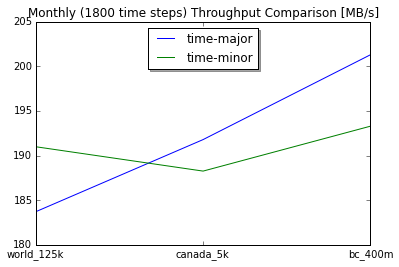

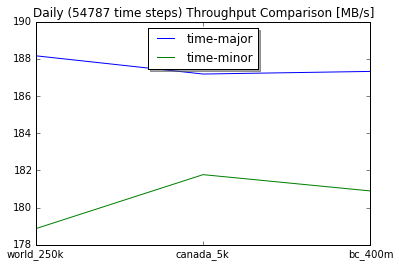

In [353]:
import matplotlib.pyplot as plt
%matplotlib inline
monthly_tmaj, = plt.plot([point[0][2] for point in monthly_step_read_throughput_time_major], label='time-major')
monthly_tmin, = plt.plot([point[0][2] for point in monthly_step_read_throughput_time_minor], label='time-minor')
plt.xticks(range(len(monthly_grid_sizes)), monthly_grid_sizes)
plt.title('Monthly (1800 time steps) Throughput Comparison [MB/s]')
plt.legend(loc='upper center', shadow=True)
plt.show()

daily_tmaj, = plt.plot([point[0][2] for point in daily_step_read_throughput_time_major], label='time-major')
daily_tmin, = plt.plot([point[0][2] for point in daily_step_read_throughput_time_minor], label='time-minor')
plt.xticks(range(len(daily_grid_sizes)), daily_grid_sizes)
plt.title('Daily (54787 time steps) Throughput Comparison [MB/s]')
plt.legend(loc='upper center', shadow=True)
plt.show()

### There seems to be a slightly higher throughput for reading out of large time-major NetCDF data files vs. time-minor (on the order of ~7MB/sec)